<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# Musterlösung / Sample solution 
## 10th exercise: <font color="#C70039">Interpretable Machine Learning with Shapley Values for image classification</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Student: Tim Köhne 
* Matriculation number: 11147022
* Date: 07.12.2025

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
This is one implementation example to demo XAI for image classification using the inbuild cifar-10 data set, that you have come across with in exercise 8 already.

In [2]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.datasets import cifar10

2025-12-07 21:28:08.105176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load dataset
### load build-in dataset and preprocess
Take the cifar-10 data set from exercise 8

In [3]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Use original 32x32 images
x_train_processed = preprocess_input(np.array(x_train).astype(np.float32))
x_test_processed = preprocess_input(np.array(x_test).astype(np.float32))

# Reshape images for KernelExplainer (flatten pixels - see below)
# KernelExplainer expects 1 or 2 dimensions. We'll reshape to (samples, num_features)
num_test_samples = x_test_processed[:5].shape[0]
flattened_test_images = x_test_processed[:5].reshape(num_test_samples, -1)

num_train_samples = x_train_processed[:50].shape[0]
flattened_train_images = x_train_processed[:50].reshape(num_train_samples, -1)

# Explicitly convert background data to numpy array with float32 dtype
flattened_train_images = np.array(flattened_train_images).astype(np.float32)

## Modeling
### Use a pretrained Model (here MobileNetV2)

In [4]:
# Using include_top=False to remove the classification layer, as we have 10 classes in CIFAR-10
# Adjusted input_shape to 32x32
'''Note: Using imagenet weights on 32x32 input might not be ideal since it was trained on much larger imnages'''
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add a new classification layer for CIFAR-10
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Wrap the model's predict function for KernelExplainer
# This function needs to accept the flattened input and reshape it back for the model
def predict_fn_for_kernel(flattened_images):
    # Reshape flattened images back to original shape for prediction
    original_shape = (-1, 32, 32, 3)
    images = flattened_images.reshape(original_shape)
    return model.predict(images)

/tmp/ipykernel_1782715/3166235171.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
I0000 00:00:1765139354.323341 1782715 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1359 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:2b:00.0, compute capability: 8.9


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Initialize the KernelExplainer 

In [5]:
# Kernel explainer works with the model's predict function
# It requires a background dataset in the flattened format
# Using a smaller subset for demonstration due to memory constraints
explainer = shap.KernelExplainer(predict_fn_for_kernel, flattened_train_images)

2025-12-07 21:30:57.873437: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f5020002ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-07 21:30:57.873453: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-12-07 21:30:57.897773: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-07 21:30:58.184595: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-12-07 21:31:02.070727: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 21:31:02.150729: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: 

1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step

I0000 00:00:1765139463.024942 1783452 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-12-07 21:31:07.396971: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 21:31:07.476993: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 21:31:07.556976: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step


## Calculate Shapley-values for test images

In [6]:
# Using a smaller subset for demonstration
# nsamples can be increased for better accuracy, but increases computation time
shap_values = explainer.shap_values(flattened_test_images, nsamples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

2025-12-07 21:31:29.363872: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 21:31:29.447779: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 21:31:29.526209: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
137/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-12-07 21:31:34.749260: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 21:31:34.835370: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 21:31:34.915473: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


/home/tim/Projects/AML/.venv/lib/python3.13/site-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/home/tim/Projects/AML/.venv/lib/python3.13/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.611e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/tim/Projects/AML/.venv/lib/python3.13/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.666e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/tim/Projects/AML/.venv/lib/python3.13/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.682e-03, with an active set of 7 regre

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/home/tim/Projects/AML/.venv/lib/python3.13/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.273e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/tim/Projects/AML/.venv/lib/python3.13/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.159e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/tim/Projects/AML/.venv/lib/python3.13/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.326e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Visualization of an explanation example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.7411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..0.9529412].


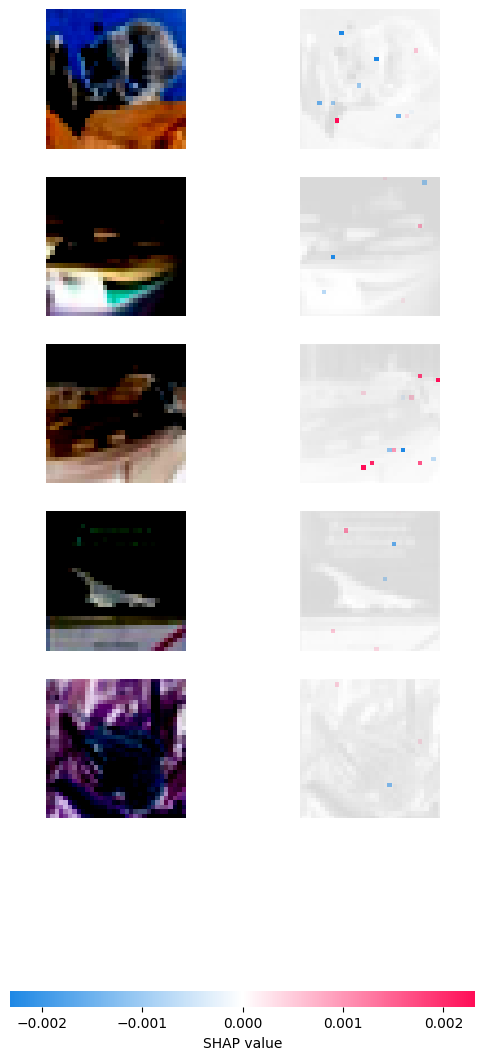

In [7]:
# KernelExplainer's shap_values output format can vary.
# For multi-output models, it's often a list of arrays.
# We'll reshape the shap values back to image shape for plotting.
# The second argument to image_plot should be the original images.
# shap_values is a list, each element is a shapley value array for a class, shape (num_samples, num_features)
# We need to reshape each of these back to image shape (num_samples, height, width, channels)
shap_values_reshaped = [
    s.reshape((-1, 32, 32, 3)) for s in shap_values
]

# We'll plot the shap values for the first class (index 0).
# The second argument to image_plot should be the original images.
shap.image_plot(shap_values_reshaped[0], -x_test_processed[:5])